In [19]:
import math
import random
from collections import deque
from random import sample

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
class FieldGoalEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self):
        super().__init__()

        # Observation space
        low = np.array([25.0, -50.0, -50.0, -5.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high = np.array([75.0, 50.0, 50.0, 5.0, 100.0, 100.0, 1.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Action space
        self.velocities_mph = np.arange(50, 101, 5, dtype=np.float32)     
        self.vert_angles_deg = np.arange(20, 61, 4, dtype=np.float32)     
        self.horiz_angles_deg = np.arange(-20, 21, 4, dtype=np.float32)    

        self.n_v = len(self.velocities_mph)
        self.n_va = len(self.vert_angles_deg)
        self.n_ha = len(self.horiz_angles_deg)

        self.action_space = spaces.Discrete(self.n_v * self.n_va * self.n_ha)

        # Physics constants
        self.g = 32.174
        self.goal_x = 0.0
        self.crossbar_height_ft = 10.0
        self.post_half_width_ft = 9.25
        self.yards_per_ft = 1.0 / 3.0

        # Reward constants (yds)
        self.reward_make = 100.0
        self.reward_miss = -100.0
        self.short_penalty_per_yard = 3.0
        self.deep_penalty_per_yard = 1.0
        self.lateral_penalty_per_yard = 3.0

        # Base execution noise
        self.base_speed_noise_std_mph = 0.5
        self.base_angle_noise_std_deg = 0.25

        self.state = None
        self.last_info = {}

    def _decode_action(self, action):
        a = int(action)
        v_idx = a // (self.n_va * self.n_ha)
        rem = a % (self.n_va * self.n_ha)
        va_idx = rem // self.n_ha
        ha_idx = rem % self.n_ha

        v_mph = float(self.velocities_mph[v_idx])
        va_deg = float(self.vert_angles_deg[va_idx])
        ha_deg = float(self.horiz_angles_deg[ha_idx])
        return v_mph, va_deg, ha_deg

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        distance_yards = self.np_random.integers(25, 76)
        headwind_ft_s = self.np_random.integers(-50, 51)
        crosswind_ft_s = self.np_random.integers(-50, 51)
        hashmark_yards = float(self.np_random.choice([
            -9.25 * self.yards_per_ft,
            9.25 * self.yards_per_ft  
        ]))
        pressure = float(self.np_random.integers(0, 101))
        temperature = float(self.np_random.integers(0, 101))
        slip = float(self.np_random.random())

        obs = np.array(
            [distance_yards,
             headwind_ft_s,
             crosswind_ft_s,
             hashmark_yards,
             pressure,
             temperature,
             slip],
            dtype=np.float32,
        )
        self.state = obs
        self.last_info = {}
        return obs, {}

    def step(self, action):
        assert self.state is not None, "Call reset() before step()."
        assert self.action_space.contains(action), "Invalid action."

        (distance_yards,
         headwind_ft_s,
         crosswind_ft_s,
         hashmark_yards,
         pressure,
         temperature,
         slip) = self.state

        distance_ft = float(distance_yards) / self.yards_per_ft
        x0 = -distance_ft
        y0 = float(hashmark_yards) / self.yards_per_ft
        z0 = 0.0
        
        v_mph_nom, va_deg_nom, ha_deg_nom = self._decode_action(action)

        temp_norm = float(temperature) / 100.0 
        temp_scale = 0.85 + 0.30 * temp_norm  
        v_mph_temp = v_mph_nom * temp_scale

        pressure_norm = float(pressure) / 100.0  
        slip_norm = float(slip)                 

        noise_factor = 1.0 + 1.5 * pressure_norm + 1.5 * slip_norm
        speed_noise_std = self.base_speed_noise_std_mph * noise_factor
        angle_noise_std = self.base_angle_noise_std_deg * noise_factor

        v_mph_noisy = v_mph_temp + np.random.normal(0.0, speed_noise_std)
        va_deg_noisy = va_deg_nom + np.random.normal(0.0, angle_noise_std)
        ha_deg_noisy = ha_deg_nom + np.random.normal(0.0, angle_noise_std)

        v_mph_noisy = max(10.0, v_mph_noisy)
        va_deg_noisy = float(np.clip(va_deg_noisy, 10.0, 75.0))
        ha_deg_noisy = float(np.clip(ha_deg_noisy, -30.0, 30.0))

        v0 = v_mph_noisy * 1.4666667
        theta = math.radians(va_deg_noisy)  
        phi = math.radians(ha_deg_noisy)   

        vx0 = v0 * math.cos(theta) * math.cos(phi)
        vy0 = v0 * math.cos(theta) * math.sin(phi)
        vz0 = v0 * math.sin(theta)

        vx_eff = vx0 + float(headwind_ft_s)
        vy_eff = vy0 + float(crosswind_ft_s)

        if vz0 <= 0.0:
            t_land = 0.0
        else:
            t_land = 2.0 * vz0 / self.g

        x_land = x0 + vx_eff * t_land
        y_land = y0 + vy_eff * t_land

        crosses_plane_in_air = False
        t_goal = None
        y_at_goal = None
        z_at_goal = None

        if vx_eff > 1e-6:
            t_candidate = -x0 / vx_eff
            if 0.0 < t_candidate < t_land + 1e-6:
                t_goal = t_candidate
                z_at_goal = vz0 * t_goal - 0.5 * self.g * t_goal ** 2
                if z_at_goal is not None and z_at_goal > 0.0:
                    y_at_goal = y0 + vy_eff * t_goal
                    crosses_plane_in_air = True

        made_fg = False
        if crosses_plane_in_air:
            if (z_at_goal >= self.crossbar_height_ft and
                    abs(y_at_goal) <= self.post_half_width_ft):
                made_fg = True

        reward = self.reward_make if made_fg else self.reward_miss

        if x_land < self.goal_x:
            yards_short = (self.goal_x - x_land) * self.yards_per_ft
            reward -= self.short_penalty_per_yard * yards_short
        else:
            yards_deep = (x_land - self.goal_x) * self.yards_per_ft
            reward -= self.deep_penalty_per_yard * yards_deep

        if crosses_plane_in_air:
            lateral_ft = abs(y_at_goal)
        else:
            lateral_ft = abs(y_land)
        lateral_yards = lateral_ft * self.yards_per_ft
        reward -= self.lateral_penalty_per_yard * lateral_yards

        info = {
            "made": made_fg,
            "distance_yards": float(distance_yards),
            "headwind_ft_s": float(headwind_ft_s),
            "crosswind_ft_s": float(crosswind_ft_s),
            "hashmark_yards": float(hashmark_yards),
            "pressure": float(pressure),
            "temperature_F": float(temperature),
            "slip": float(slip),
            "x_land_ft": float(x_land),
            "y_land_ft": float(y_land),
            "t_land_s": float(t_land),
            "crosses_plane_in_air": bool(crosses_plane_in_air),
            "t_goal_s": float(t_goal) if t_goal is not None else None,
            "y_at_goal_ft": float(y_at_goal) if y_at_goal is not None else None,
            "z_at_goal_ft": float(z_at_goal) if z_at_goal is not None else None,
            "action_velocity_mph_nominal": v_mph_nom,
            "action_vert_angle_deg_nominal": va_deg_nom,
            "action_horiz_angle_deg_nominal": ha_deg_nom,
            "velocity_mph_noisy": v_mph_noisy,
            "vert_angle_deg_noisy": va_deg_noisy,
            "horiz_angle_deg_noisy": ha_deg_noisy,
        }
        self.last_info = info

        terminated = True
        truncated = False
        obs = self.state.astype(np.float32)
        return obs, float(reward), terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

In [15]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x):
        return self.model(x)

class FieldGoalAgent:
    def __init__(self, env, discount=0.99, learning_rate=0.001,
                 buffer_size=100000, batch_size=64, target_update_freq=2000,
                 epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.999):
        self.env = env
        self.discount = discount
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.step_count = 0

        self.replay_buffer = deque(maxlen=buffer_size)

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def action_select(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state_t)
        return int(torch.argmax(q_values).item())

    def update(self, state, action, reward, next_state, terminated):
        self.replay_buffer.append((state, action, reward, next_state, terminated))

        if len(self.replay_buffer) < self.batch_size:
            return

        batch = sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32, device=device)
        actions = torch.tensor(np.array(actions), dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
        terminations = torch.tensor(np.array(dones), dtype=torch.int64, device=device).unsqueeze(1)

        q_values = self.q_network(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(dim=1)[0].unsqueeze(1)
            target_q = rewards + (1 - terminations) * self.discount * max_next_q

        loss = self.loss_fn(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

In [16]:
def train(agent, env, n_episodes=2000, print_every=1000):
    episode_returns = []
    episode_successes = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0.0
        ep_success = False

        while not done:
            action = agent.action_select(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.update(state, action, reward, next_state, terminated)

            ep_return += reward
            if terminated or truncated:
                ep_success = info.get("made", False)

            state = next_state
            done = terminated or truncated

        episode_returns.append(ep_return)
        episode_successes.append(ep_success)

        if print_every and (episode + 1) % print_every == 0:
            avg_ret = np.mean(episode_returns[-print_every:])
            print(f"Episode {episode + 1}: average return (last {print_every}) = {avg_ret:.2f}")

    return agent, env, np.array(episode_returns), np.array(episode_successes, dtype=bool)


def plot_training_stats(episode_returns, episode_successes, chunk_size=1000):
    n = len(episode_returns)
    n_chunks = math.ceil(n / chunk_size)

    avg_returns = []
    success_rates = []
    chunks = []

    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, n)
        chunk_returns = episode_returns[start:end]
        chunk_successes = episode_successes[start:end]

        avg_returns.append(np.mean(chunk_returns))
        success_rates.append(np.mean(chunk_successes))
        chunks.append(i + 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(chunks, [sr * 100 for sr in success_rates], marker="o")
    axs[0].set_xlabel(f"Chunk (each {chunk_size} episodes)")
    axs[0].set_ylabel("Success rate (%)")
    axs[0].set_title("Training: Success Rate per Chunk")

    axs[1].plot(chunks, avg_returns, marker="o")
    axs[1].set_xlabel(f"Chunk (each {chunk_size} episodes)")
    axs[1].set_ylabel("Average reward")
    axs[1].set_title("Training: Average Reward per Chunk")

    plt.tight_layout()
    plt.show()

In [17]:
def _bin_stats(values, successes, rewards, bins, labels):
    success_rates = []
    avg_rewards = []
    for (low, high), label in zip(bins, labels):
        mask = (values >= low) & (values <= high)
        if np.any(mask):
            success_rates.append(np.mean(successes[mask]))
            avg_rewards.append(np.mean(rewards[mask]))
        else:
            success_rates.append(np.nan)
            avg_rewards.append(np.nan)
    return np.array(success_rates), np.array(avg_rewards)

def evaluate_policy(agent, env, n_episodes=1000):
    """
    Greedy evaluation and plots:
      - overall success rate & avg reward
      - distance vs headwind scatter
      - success by distance, headwind, crosswind, pressure, temperature, slip
    """
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0

    successes = []
    rewards = []
    distances = []
    headwinds = []
    crosswinds = []
    pressures = []
    temps = []
    slips = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        action = agent.action_select(state)
        _, reward, _, _, info = env.step(action)

        rewards.append(reward)
        distances.append(info["distance_yards"])
        headwinds.append(info["headwind_ft_s"])
        crosswinds.append(info["crosswind_ft_s"])
        pressures.append(info["pressure"])
        temps.append(info["temperature_F"])
        slips.append(info["slip"])
        successes.append(info["made"])

    rewards = np.array(rewards)
    distances = np.array(distances)
    headwinds = np.array(headwinds)
    crosswinds = np.array(crosswinds)
    pressures = np.array(pressures)
    temps = np.array(temps)
    slips = np.array(slips)
    successes = np.array(successes, dtype=bool)

    success_rate = successes.mean()
    avg_reward = rewards.mean()

    print(f"Evaluation over {n_episodes} episodes:")
    print(f"  Success rate: {success_rate * 100:.2f}%")
    print(f"  Average reward: {avg_reward:.2f}")
    
    X = np.column_stack([
        distances,
        headwinds,
        crosswinds,
        pressures,
        temps,
        slips,
    ])
        
    y = successes.astype(int)

    feature_names = [
        "distance_yards",
        "headwind_ft_s",
        "crosswind_ft_s",
        "pressure",
        "temperature_F",
        "slip",
    ]
    
    if len(np.unique(y)) > 1:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_scaled, y)

        coefs = np.abs(logreg.coef_[0])

        plt.figure(figsize=(8, 5))
        plt.bar(feature_names, coefs)
        plt.xticks(rotation=25)
        plt.ylabel("Absolute logistic coefficient")
        plt.title("Feature Importance (Individual Influence on Make Probability)")
        plt.tight_layout()
        plt.show()

    dist_bins = [(25, 34), (35, 44), (45, 54), (55, 64), (65, 75)]
    dist_labels = [f"{lo}-{hi}" for lo, hi in dist_bins]
    dist_sr, _ = _bin_stats(distances, successes, rewards, dist_bins, dist_labels)

    plt.figure(figsize=(8, 5))
    plt.bar(dist_labels, dist_sr * 100)
    plt.xlabel("Distance (yards)")
    plt.ylabel("Success rate (%)")
    plt.title("Success Rate by Distance")
    plt.tight_layout()
    plt.show()

    wind_bins = [(-50, -30), (-30, -10), (-10, 10), (10, 30), (30, 50)]
    wind_labels = ["Strong headwind", "Moderate headwind",
                   "Calm", "Moderate tailwind", "Strong tailwind"]
    head_sr, _ = _bin_stats(headwinds, successes, rewards, wind_bins, wind_labels)

    plt.figure(figsize=(9, 5))
    plt.bar(wind_labels, head_sr * 100)
    plt.xticks(rotation=20)
    plt.xlabel("Headwind bin (ft/s)")
    plt.ylabel("Success rate (%)")
    plt.title("Success Rate by Headwind")
    plt.tight_layout()
    plt.show()

    cross_bins = [(-50, -30), (-30, -10), (-10, 10), (10, 30), (30, 50)]
    cross_labels = ["Strong left", "Moderate left", "Calm", "Moderate right", "Strong right"]
    cross_sr, _ = _bin_stats(crosswinds, successes, rewards, cross_bins, cross_labels)

    plt.figure(figsize=(9, 5))
    plt.bar(cross_labels, cross_sr * 100)
    plt.xticks(rotation=20)
    plt.xlabel("Crosswind bin (ft/s)")
    plt.ylabel("Success rate (%)")
    plt.title("Success Rate by Crosswind")
    plt.tight_layout()
    plt.show()

    pressure_bins = [(0, 33), (34, 66), (67, 100)]
    pressure_labels = ["Low pressure", "Medium pressure", "High pressure"]
    pressure_sr, _ = _bin_stats(pressures, successes, rewards, pressure_bins, pressure_labels)

    plt.figure(figsize=(8, 5))
    plt.bar(pressure_labels, pressure_sr * 100)
    plt.xlabel("Pressure level")
    plt.ylabel("Success rate (%)")
    plt.title("Success Rate by Pressure")
    plt.tight_layout()
    plt.show()

    temp_bins = [(0, 33), (34, 66), (67, 100)]
    temp_labels = ["Cold", "Mild", "Warm"]
    temp_sr, _ = _bin_stats(temps, successes, rewards, temp_bins, temp_labels)

    plt.figure(figsize=(8, 5))
    plt.bar(temp_labels, temp_sr * 100)
    plt.xlabel("Temperature range (°F)")
    plt.ylabel("Success rate (%)")
    plt.title("Success Rate by Temperature")
    plt.tight_layout()
    plt.show()

    slip_bins = [(0.0, 0.33), (0.34, 0.66), (0.67, 1.0)]
    slip_labels = ["Low slip", "Medium slip", "High slip"]
    slip_sr, _ = _bin_stats(slips, successes, rewards, slip_bins, slip_labels)

    plt.figure(figsize=(8, 5))
    plt.bar(slip_labels, slip_sr * 100)
    plt.xlabel("Slip level")
    plt.ylabel("Success rate (%)")
    plt.title("Success Rate by Slip")
    plt.tight_layout()
    plt.show()

    agent.epsilon = old_epsilon

In [18]:
def inspect_policy(agent, env):
    old_eps = agent.epsilon
    agent.epsilon = 0.0

    left_hash_yards = -9.25 * env.yards_per_ft
    right_hash_yards = 9.25 * env.yards_per_ft

    scenarios = [
        dict(distance=30, headwind=0,  crosswind=0,
             hashmark=left_hash_yards, pressure=10, temp=75, slip=0.1),

        dict(distance=40, headwind=0,  crosswind=40,
             hashmark=right_hash_yards, pressure=50, temp=65, slip=0.2),

        dict(distance=55, headwind=-40, crosswind=0,
             hashmark=left_hash_yards, pressure=90, temp=55, slip=0.4),

        dict(distance=60, headwind=40, crosswind=30,
             hashmark=right_hash_yards, pressure=70, temp=60, slip=0.9),

        dict(distance=45, headwind=-10, crosswind=-25,
             hashmark=left_hash_yards, pressure=60, temp=20, slip=0.8),

        dict(distance=50, headwind=0, crosswind=0,
             hashmark=right_hash_yards, pressure=95, temp=10, slip=0.3),

        dict(distance=65, headwind=0, crosswind=0,
             hashmark=left_hash_yards, pressure=20, temp=80, slip=0.0),

        dict(distance=40, headwind=-45, crosswind=-45,
             hashmark=right_hash_yards, pressure=80, temp=35, slip=1.0),

        dict(distance=27, headwind=5, crosswind=-10,
             hashmark=left_hash_yards, pressure=100, temp=65, slip=0.2),

        dict(distance=50, headwind=0, crosswind=40,
             hashmark=right_hash_yards, pressure=50, temp=60, slip=0.3),
    ]

    print("\nSample policy choices under different conditions:\n")

    for i, sc in enumerate(scenarios, start=1):
        state = np.array([
            sc["distance"],
            sc["headwind"],
            sc["crosswind"],
            sc["hashmark"],
            sc["pressure"],
            sc["temp"],
            sc["slip"],
        ], dtype=np.float32)

        action = agent.action_select(state)
        v_mph, va_deg, ha_deg = env._decode_action(action)

        env.state = state.copy()
        _, reward, _, _, info = env.step(action)

        made = info["made"]
        noisy_v = info["velocity_mph_noisy"]
        noisy_va = info["vert_angle_deg_noisy"]
        noisy_ha = info["horiz_angle_deg_noisy"]

        hash_side = "L" if sc["hashmark"] < 0 else "R"
        if ha_deg > 0:
            dir_str = "right"
        elif ha_deg < 0:
            dir_str = "left"
        else:
            dir_str = "center"

        print(f"Scenario {i}:")
        print(f"  Conditions:")
        print(f"    Distance    : {sc['distance']} yards")
        print(f"    Headwind    : {sc['headwind']} ft/s")
        print(f"    Crosswind   : {sc['crosswind']} ft/s")
        print(f"    Hashmark    : {sc['hashmark']:.3f} yards ({hash_side} hash)")
        print(f"    Pressure    : {sc['pressure']} / 100")
        print(f"    Temperature : {sc['temp']} °F")
        print(f"    Slip        : {sc['slip']:.2f}")
        print(f"  Agent choice:")
        print(f"    Velocity        : {v_mph:.1f} mph")
        print(f"    Vertical angle  : {va_deg:.1f}°")
        print(f"    Horizontal angle: {ha_deg:.1f}° ({dir_str})")
        print(f"  Actual kicked values (after adding env noise):")
        print(f"    Velocity        : {noisy_v:.1f} mph")
        print(f"    Vertical angle  : {noisy_va:.1f}°")
        print(f"    Horizontal angle: {noisy_ha:.1f}°")
        print(f"  Outcome          : {'MAKE' if made else 'MISS'}")
        print(f"  Reward           : {reward:.2f}")
        print()

    agent.epsilon = old_eps

Episode 1000: average return (last 1000) = -217.59
Episode 2000: average return (last 1000) = -216.98
Episode 3000: average return (last 1000) = -187.10
Episode 4000: average return (last 1000) = -126.44
Episode 5000: average return (last 1000) = -92.50
Episode 6000: average return (last 1000) = -79.72
Episode 7000: average return (last 1000) = -78.00
Episode 8000: average return (last 1000) = -64.76
Episode 9000: average return (last 1000) = -64.90
Episode 10000: average return (last 1000) = -59.83
Episode 11000: average return (last 1000) = -47.18
Episode 12000: average return (last 1000) = -45.20
Episode 13000: average return (last 1000) = -42.81
Episode 14000: average return (last 1000) = -33.00
Episode 15000: average return (last 1000) = -35.93
Episode 16000: average return (last 1000) = -27.56
Episode 17000: average return (last 1000) = -21.54
Episode 18000: average return (last 1000) = -18.79
Episode 19000: average return (last 1000) = -26.48
Episode 20000: average return (last 

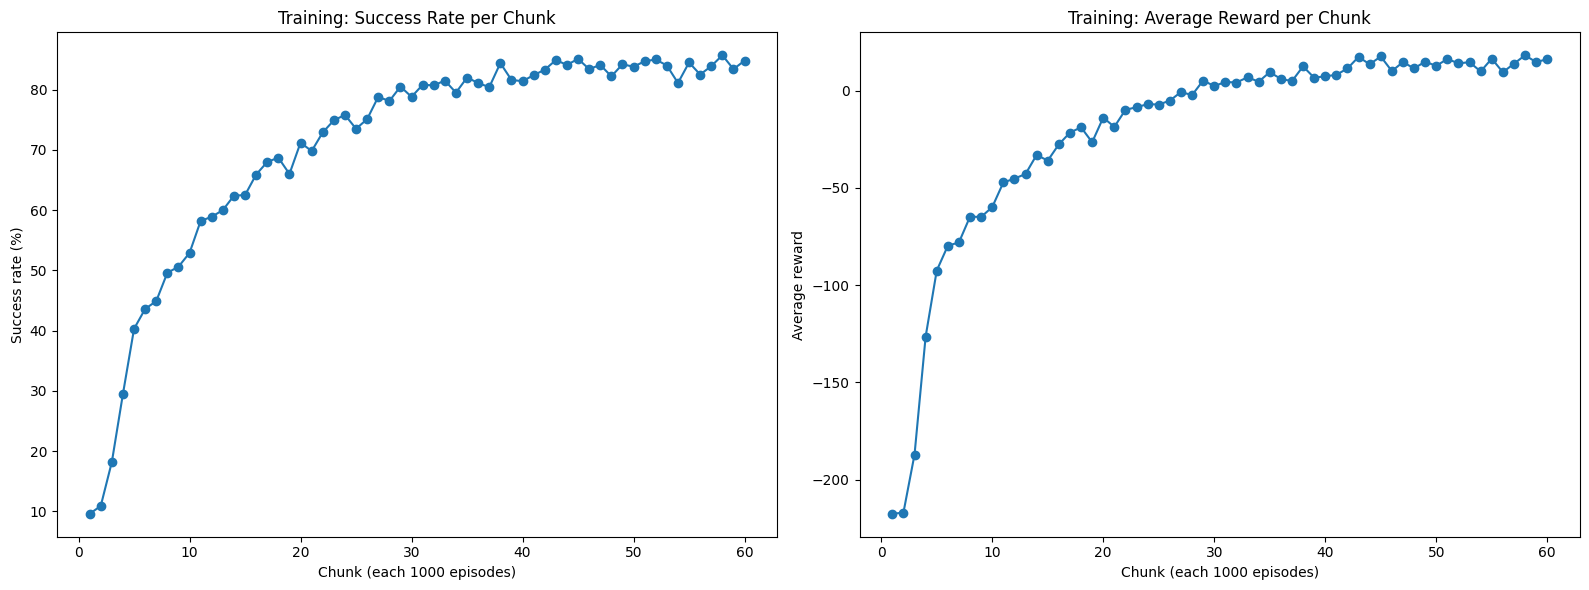

Evaluation over 1000 episodes:
  Success rate: 86.30%
  Average reward: 20.68


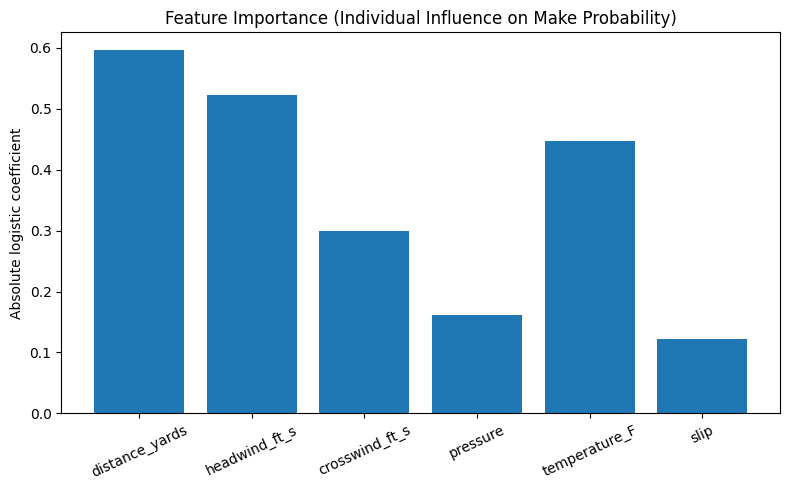

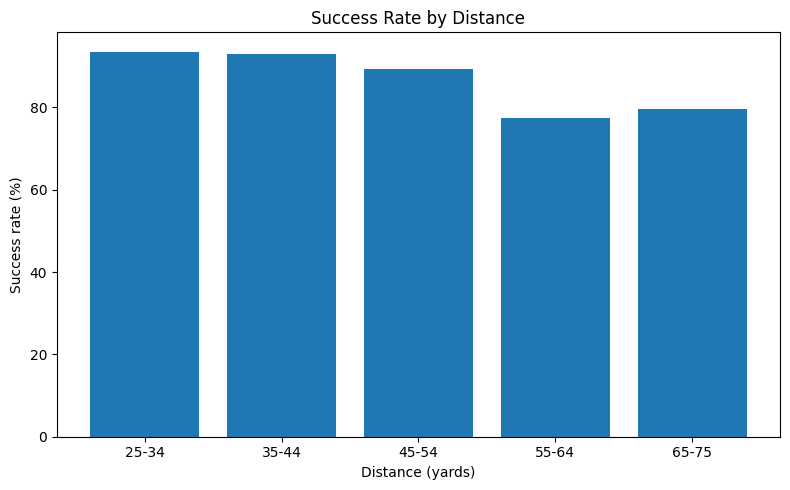

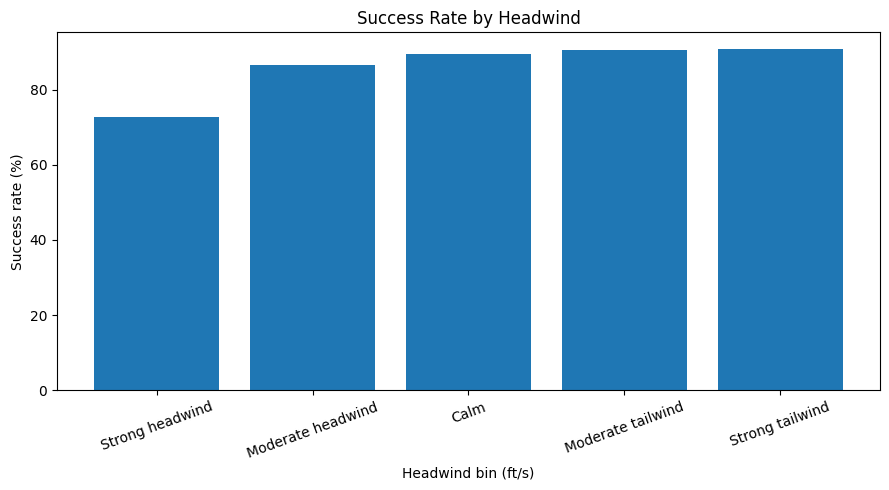

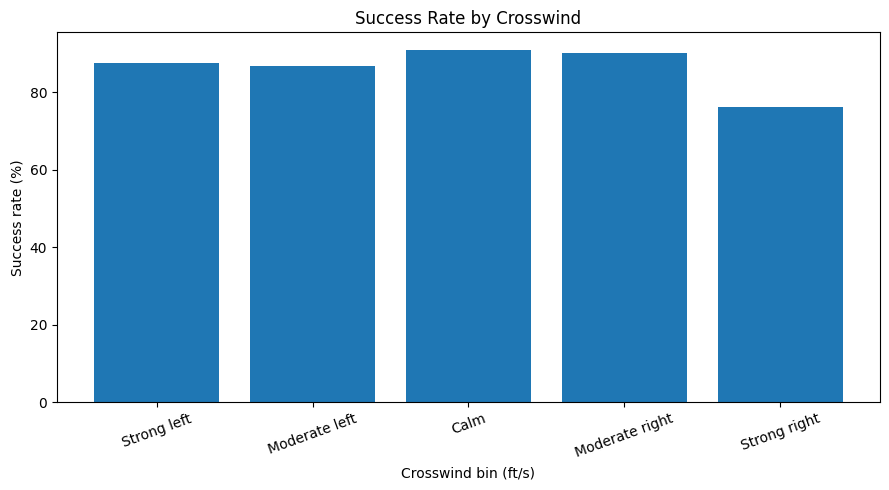

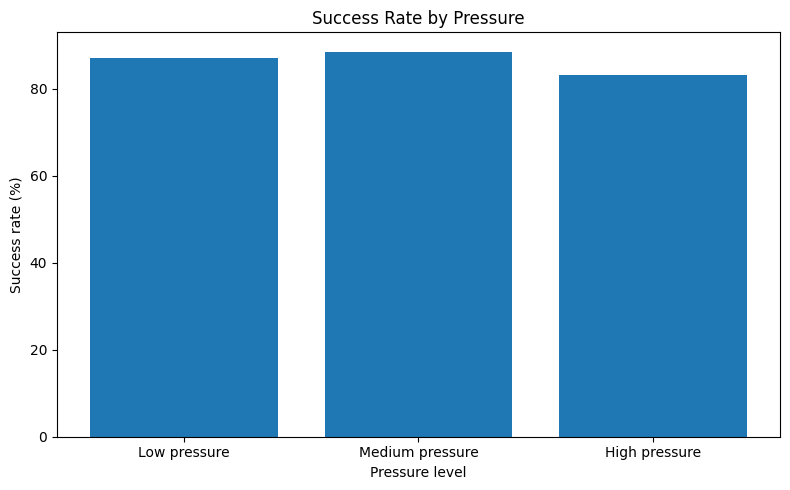

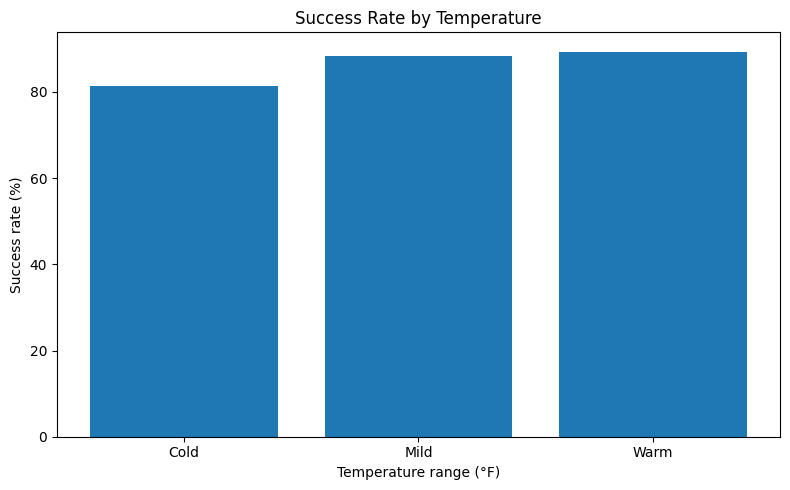

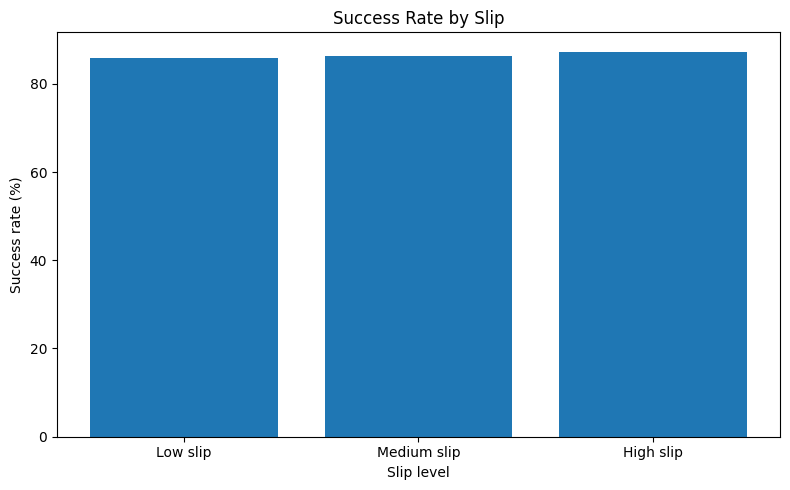


Sample policy choices under different conditions:

Scenario 1:
  Conditions:
    Distance    : 30 yards
    Headwind    : 0 ft/s
    Crosswind   : 0 ft/s
    Hashmark    : -3.083 yards (L hash)
    Pressure    : 10 / 100
    Temperature : 75 °F
    Slip        : 0.10
  Agent choice:
    Velocity        : 55.0 mph
    Vertical angle  : 36.0°
    Horizontal angle: 4.0° (right)
  Actual kicked values (after adding env noise):
    Velocity        : 58.9 mph
    Vertical angle  : 35.8°
    Horizontal angle: 4.0°
  Outcome          : MAKE
  Reward           : 53.84

Scenario 2:
  Conditions:
    Distance    : 40 yards
    Headwind    : 0 ft/s
    Crosswind   : 40 ft/s
    Hashmark    : 3.083 yards (R hash)
    Pressure    : 50 / 100
    Temperature : 65 °F
    Slip        : 0.20
  Agent choice:
    Velocity        : 90.0 mph
    Vertical angle  : 20.0°
    Horizontal angle: -20.0° (left)
  Actual kicked values (after adding env noise):
    Velocity        : 94.1 mph
    Vertical angle  : 20

In [12]:
base_env = FieldGoalEnv()
training_episodes = 60000

env = gym.wrappers.RecordEpisodeStatistics(base_env, buffer_length=training_episodes)
agent = FieldGoalAgent(env)

agent, env, train_returns, train_successes = train(
    agent, env, n_episodes=training_episodes, print_every=1000
)

plot_training_stats(train_returns, train_successes, chunk_size=1000)
evaluate_policy(agent, base_env, n_episodes=1000)
inspect_policy(agent, base_env)